# ---START: Technical Requirements---


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
from statsmodels.tools.eval_measures import rmspe, rmse
from sklearn.metrics import mean_absolute_percentage_error as mape
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose, STL
from statsmodels.tsa.stattools import kpss, adfuller
from itertools import product
import statsmodels as sm
from pathlib import Path


warnings.filterwarnings('ignore')
plt.rcParams["figure.figsize"] = [12, 3]

In [3]:
sm.__version__

'0.13.1'

In [4]:
life_file = Path('../../datasets/Ch10/life_expectancy_birth.csv')
milk_file = Path('../../datasets/Ch10/milk_production.csv')

life = pd.read_csv(life_file, 
                   index_col='year',
                   parse_dates=True,
                   skipfooter=1)

milk = pd.read_csv(milk_file, 
                   index_col='month', 
                   parse_dates=True)

In [5]:
life.shape

(59, 1)

In [6]:
milk.shape

(168, 1)

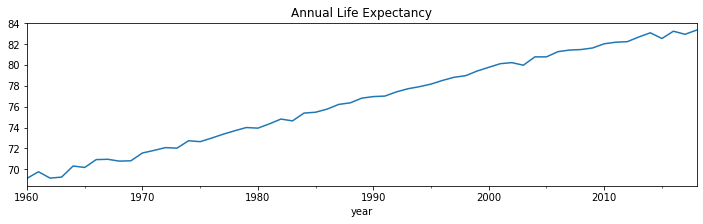

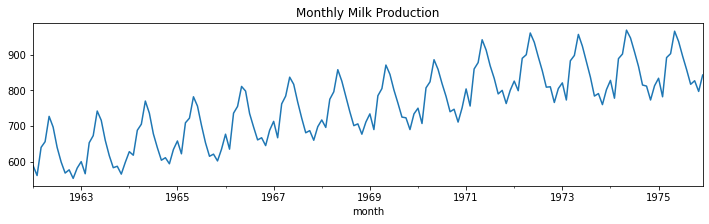

In [7]:
life.plot(title='Annual Life Expectancy', 
                        legend=False)
milk.plot(title='Monthly Milk Production', 
                        legend=False)

plt.show()

In [8]:
def split_data(data, test_split):
    l = len(data)
    t_idx = round(l*(1-test_split))
    train = data[ : t_idx]
    test = data[t_idx : ]

    print(f'train: {len(train)} , test: {len(test)}')
    return train, test

In [9]:
test_split = 0.15
milk_train, milk_test = split_data(milk, test_split)
life_train, life_test = split_data(life, test_split)

train: 143 , test: 25
train: 50 , test: 9


In [10]:
def check_stationarity(df):
    results = adfuller(df)[1:3]
    s = 'Non-Stationary'
    if results[0] < 0.05:
        s = 'Stationary'
    print(f"'{s}\t p-value:{results[0]} \t lags:{results[1]}")
    return (s, results[0])

In [11]:
def get_best_model(score, c='AIC'):
    initial_score = score[0][c]
    best_model = 0
    for k,v in score.items():
        if v[c] < initial_score:
            initial_score = v[c]
            best_model = k
    print(f'Best model: {best_model} with lowest {c} score: {initial_score}')
    return score[best_model]['model']

In [12]:
def plot_forecast(model, start, train, test):
    forecast = pd.DataFrame(model.forecast(test.shape[0]), 
                            index=test.index)
    ax = train.loc[start:].plot(style='--')
    test.plot(ax=ax)
    forecast.plot(ax=ax, style = '-.')
    ax.legend(['orig_train', 'orig_test', 'forecast'])
    plt.show()

In [13]:
def combinator(items, r=1):
    combo = [i for i in product(*items, repeat=r)]
    return combo

# Plotting ACF and PACF

<AxesSubplot:xlabel='year'>

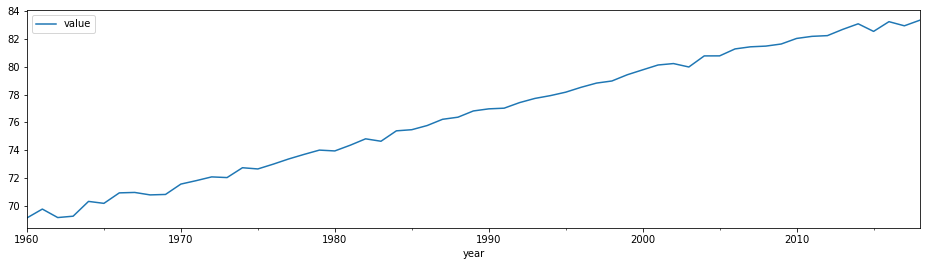

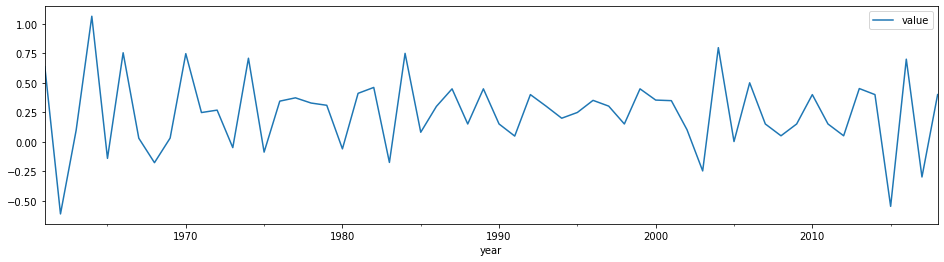

In [14]:
plt.rcParams["figure.figsize"] = [16, 4]
life.plot()
life_diff = life.diff().dropna()
life_diff.plot()

In [15]:
check_stationarity(life_diff)

'Stationary	 p-value:1.5562189676003248e-14 	 lags:1


('Stationary', 1.5562189676003248e-14)

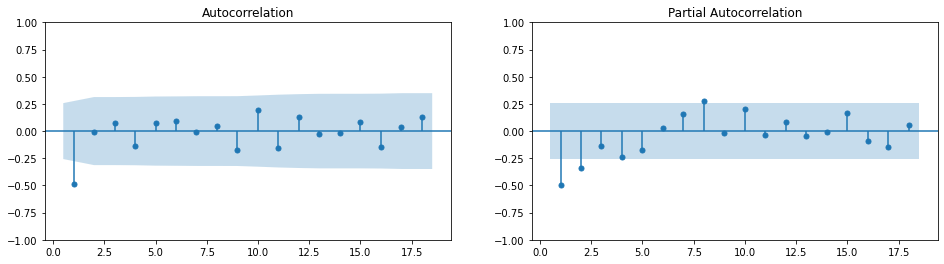

In [16]:
fig, ax = plt.subplots(1,2)
plot_acf(life_diff, zero=False, ax=ax[0])
plot_pacf(life_diff, zero=False, ax=ax[1]);plt.show()

<AxesSubplot:xlabel='month'>

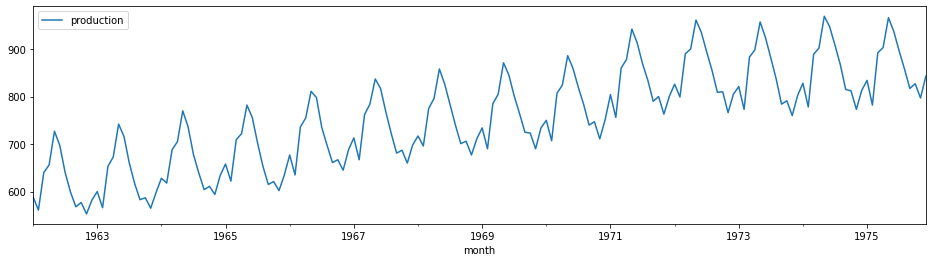

In [79]:
milk.plot()

In [80]:
milk_diff_12 = milk.diff(12).dropna()

In [53]:
check_stationarity(milk_diff_12)

'Non-Stationary	 p-value:0.16079880527711382 	 lags:12


('Non-Stationary', 0.16079880527711382)

In [54]:
milk_diff_12_1 = milk.diff(12).diff(1).dropna()
check_stationarity(milk_diff_12_1)

'Stationary	 p-value:1.865423431878876e-05 	 lags:11


('Stationary', 1.865423431878876e-05)

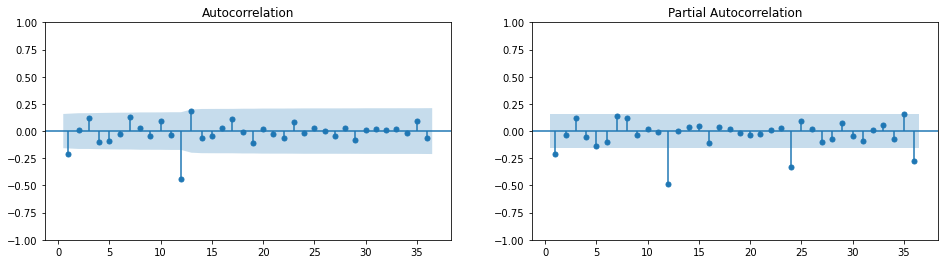

In [55]:
fig, ax = plt.subplots(1,2)
plot_acf(milk_diff_12_1, zero=False, ax=ax[0], lags=36)
plot_pacf(milk_diff_12_1, zero=False, ax=ax[1], lags=36);plt.show()

### There is more

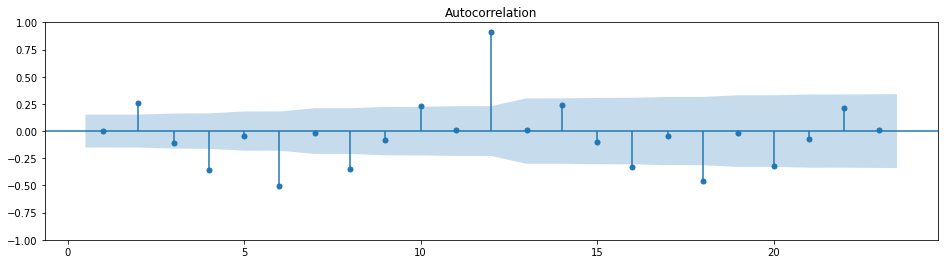

In [84]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

model = SARIMAX(milk, order=(0,1,1),
                easonal_order=(0,1,1, 12)).fit(disp=False)
plot_acf(model.resid[1:], zero=False);plt.show()

<AxesSubplot:xlabel='month'>

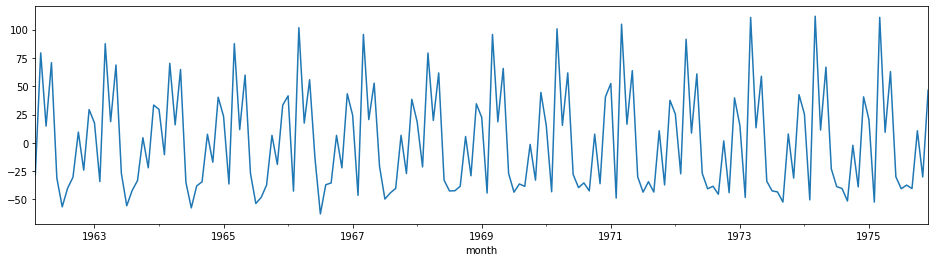

In [85]:
model.resid[1:].plot()

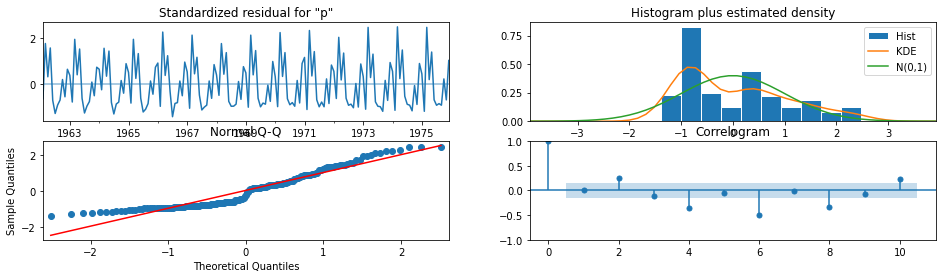

In [86]:
model.plot_diagnostics();

In [87]:
model.resid[1:]

month
1962-02-01   -28.018696
1962-03-01    79.433923
1962-04-01    14.769519
1962-05-01    70.771211
1962-06-01   -31.096291
                ...    
1975-08-01   -37.372077
1975-09-01   -40.421083
1975-10-01    10.626148
1975-11-01   -30.164606
1975-12-01    46.467269
Length: 167, dtype: float64

# Forecasting Univariate Time Series Data with Exponential Smoothing

In [88]:
from statsmodels.tsa.api import ExponentialSmoothing

In [89]:
trend = ['add', 'mul']
damped = [True, False]
life_ex_comb = combinator([trend, damped])
life_ex_comb

[('add', True), ('add', False), ('mul', True), ('mul', False)]

In [102]:
train = life_train.values.ravel()
y = life_test.values.ravel()

score = {}
for i, (t, dp) in enumerate(life_ex_comb):
    exp = ExponentialSmoothing(train, 
                     trend=t, 
                     damped_trend=dp,
                     seasonal=None).fit(use_brute=True,
                                       optimized=True)
    
    y_hat = exp.forecast(len(y))
    score[i] = {'trend':t,
                'damped':dp,
                'AIC':exp.aic,
                'BIC':exp.bic, 
                'AICc':exp.aicc,
                'RMSPE': rmspe(y, y_hat),
                'RMSE' : rmse(y, y_hat),
                'MAPE' : mape(y, y_hat),
                'model': exp}

In [103]:
life_best_model = get_best_model(score, 'AIC')

Best model: 1 with lowest AIC score: -137.03060180140557


In [104]:
life_best_model.summary()

Dep. Variable:,endog,No. Observations:,50
Model:,ExponentialSmoothing,SSE,2.749
Optimized:,True,AIC,-137.031
Trend:,Additive,BIC,-129.383
Seasonal:,None,AICC,-135.077
Seasonal Periods:,None,Date:,"Wed, 02 Feb 2022"
Box-Cox:,False,Time:,04:59:33
Box-Cox Coeff.:,None,,
,coeff,code,optimized
smoothing_level,0.1621952,alpha,True
smoothing_trend,0.1621952,beta,True


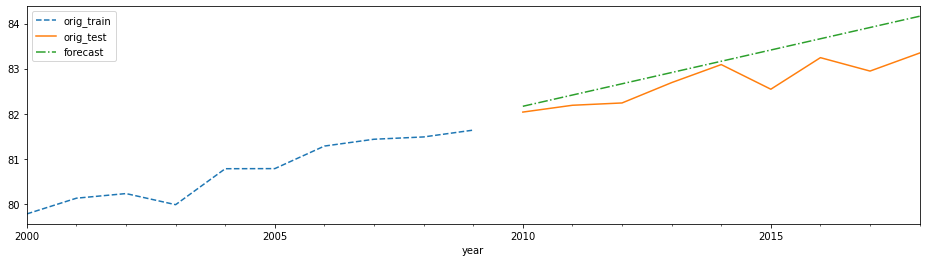

In [105]:
plot_forecast(life_best_model, '2000', life_train, life_test)

In [106]:
trend = ['add', 'mul']
damped = [True, False]
seasonal = ['add' , 'mul']
periods = [4, 6, 12]
milk_exp_comb = combinator([trend, damped, seasonal, periods])

In [116]:
train = milk_train.values.ravel()
y = milk_test.values.ravel()

milk_model_scores = {}
for i, (t, dp, s, sp) in enumerate(milk_exp_comb):
    exp = ExponentialSmoothing(train, 
                        trend=t, 
                        damped_trend=dp,
                        seasonal=s,
                        seasonal_periods=sp).fit(use_brute=True,
                                        optimized=True)
    
    y_hat = exp.forecast(len(y))
    milk_model_scores[i] = {'trend':t,
                'damped':dp,
                'AIC':exp.aic,
                'BIC':exp.bic, 
                'AICc': exp.aicc,
                'RMSPE': rmspe(y, y_hat),
                'RMSE' : rmse(y, y_hat),
                'MAPE' : mape(y, y_hat),
                'model': exp}

In [117]:
milk_model = get_best_model(milk_model_scores)

Best model: 8 with lowest AIC score: 593.7138896839506


In [118]:
milk_model.summary()

Dep. Variable:,endog,No. Observations:,143
Model:,ExponentialSmoothing,SSE,7265.655
Optimized:,True,AIC,593.714
Trend:,Additive,BIC,641.119
Seasonal:,Additive,AICC,599.230
Seasonal Periods:,12,Date:,"Wed, 02 Feb 2022"
Box-Cox:,False,Time:,05:08:17
Box-Cox Coeff.:,None,,
,coeff,code,optimized
smoothing_level,0.6859243,alpha,True
smoothing_trend,6.5801e-08,beta,True


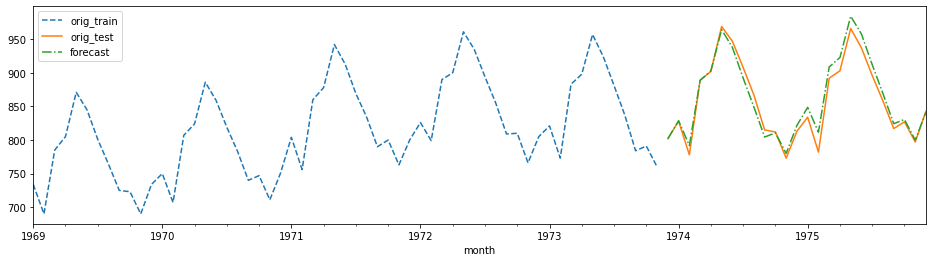

In [119]:
plot_forecast(milk_model, '1969', milk_train, milk_test)

## There is more

In [38]:
from darts.models import ExponentialSmoothing
from darts import TimeSeries

Importing plotly failed. Interactive plots will not work.


In [39]:
model = ExponentialSmoothing(seasonal_periods=12)
ts = TimeSeries.from_dataframe(milk.reset_index(), 
                                    time_col='month', value_cols='production', freq='MS')
train, test = split_data(ts, 0.15)

train: 143 , test: 25


In [40]:
model.fit(train)
forecast = model.predict(len(test), num_samples=100)

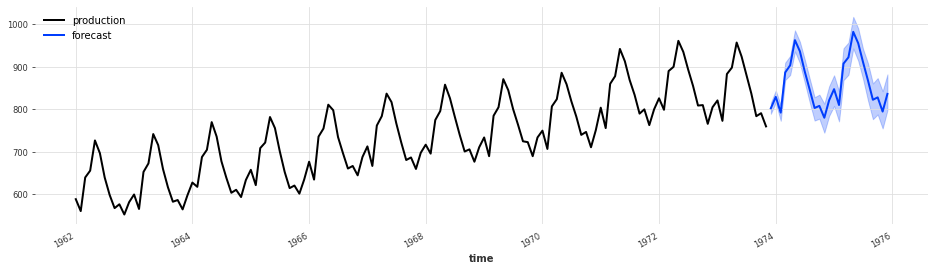

In [41]:
train.plot()
forecast.plot(label='forecast', low_quantile=0.05, high_quantile=0.95)

In [42]:
model.model.summary()

Dep. Variable:,endog,No. Observations:,143
Model:,ExponentialSmoothing,SSE,7265.655
Optimized:,True,AIC,593.714
Trend:,Additive,BIC,641.119
Seasonal:,Additive,AICC,599.230
Seasonal Periods:,12,Date:,"Thu, 13 Jan 2022"
Box-Cox:,False,Time:,01:03:52
Box-Cox Coeff.:,None,,
,coeff,code,optimized
smoothing_level,0.6859243,alpha,True
smoothing_trend,6.5801e-08,beta,True


# Forecasting Univariate Time Series Data with Non-Seasonal ARIMA

In [121]:
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.stats.diagnostic import acorr_ljungbox

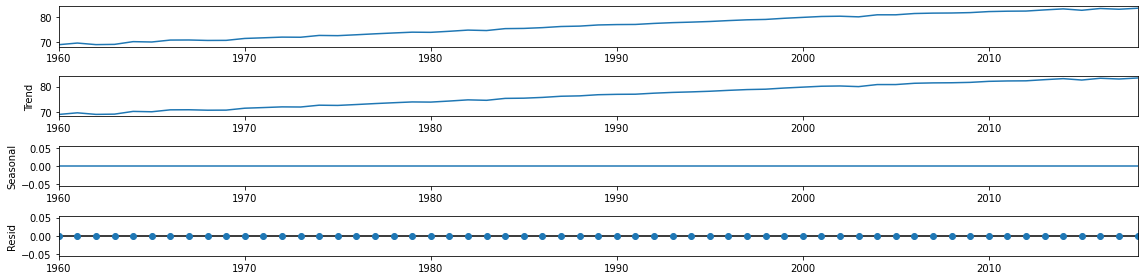

In [122]:
decomposed = seasonal_decompose(life)
decomposed.plot(); plt.show()

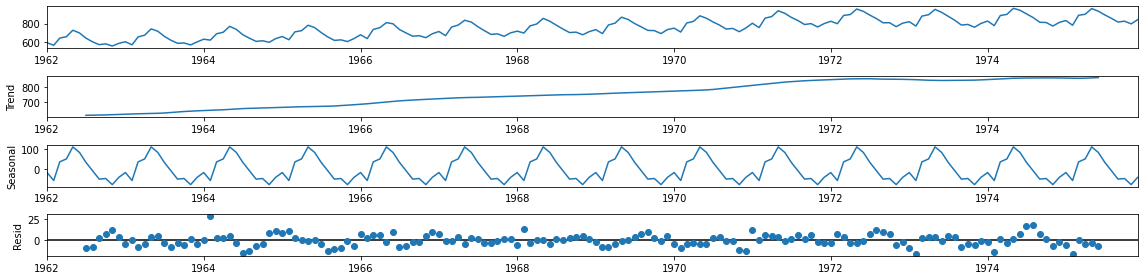

In [123]:
decomposed = seasonal_decompose(milk, period=12)
decomposed.plot(); plt.show()

In [124]:
from pandas.plotting import autocorrelation_plot

<AxesSubplot:xlabel='Lag', ylabel='Autocorrelation'>

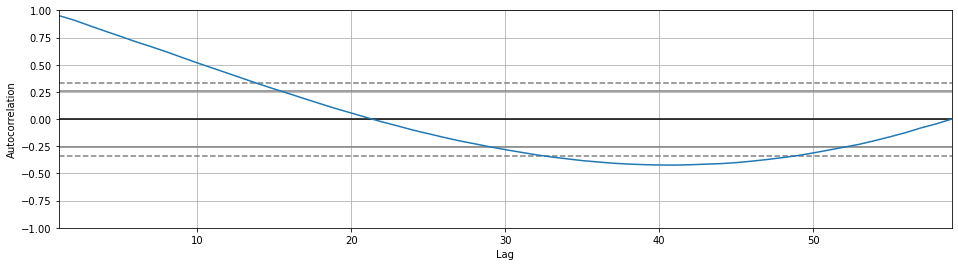

In [125]:
autocorrelation_plot(life)

In [127]:
check_stationarity(life)

'Non-Stationary	 p-value:0.6420882853800043 	 lags:2


('Non-Stationary', 0.6420882853800043)

In [131]:
life_df1 = life.diff().dropna()
check_stationarity(life_df1)

'Stationary	 p-value:1.5562189676003248e-14 	 lags:1


('Stationary', 1.5562189676003248e-14)

<AxesSubplot:xlabel='year'>

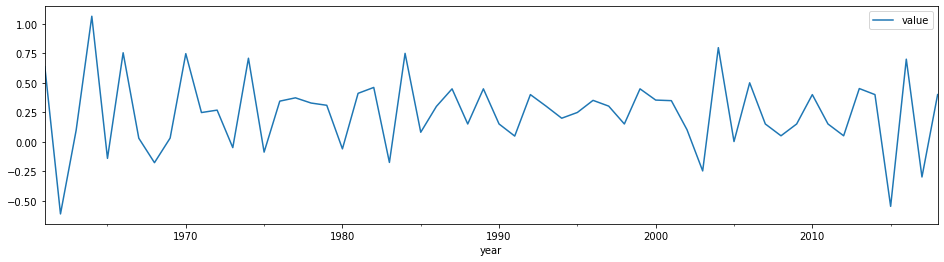

In [139]:
life_df1.plot()

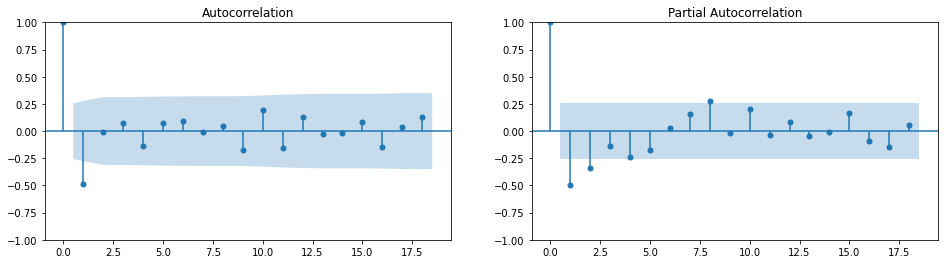

In [140]:
fig, ax = plt.subplots(1,2)
plot_acf(life_df1, ax=ax[0])
plot_pacf(life_df1, ax=ax[1]); plt.show()

In [145]:
(acorr_ljungbox(life_df1, 
                lags=25,
                return_df=True) < 0.05)['lb_pvalue'].sum()
# there is autocorrelation as we would expect 

24

In [146]:
model = ARIMA(life_train, order=(1,1,1))
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  value   No. Observations:                   50
Model:                 ARIMA(1, 1, 1)   Log Likelihood                 -13.713
Date:                Wed, 02 Feb 2022   AIC                             33.426
Time:                        09:26:56   BIC                             39.101
Sample:                    01-01-1960   HQIC                            35.579
                         - 01-01-2009                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.0000      0.023     42.715      0.000       0.954       1.046
ma.L1         -0.9962      4.072     -0.245      0.807      -8.978       6.986
sigma2         0.0957      0.385      0.248      0.804      -0.659       0.851
===================================================================================
Ljung-Box (L1) (Q):                  10.36   Jarque-Bera (JB):                 2.08
Prob(Q):                              0.00   Prob(JB):                         0.35
Heteroskedasticity (H):               0.28   Skew:                             0.39
Prob(H) (two-sided):                  0.01   Kurtosis:                         3.65
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [147]:
(acorr_ljungbox(results.resid, 
                lags=25,
                return_df=True) < 0.05)['lb_pvalue'].sum()

0

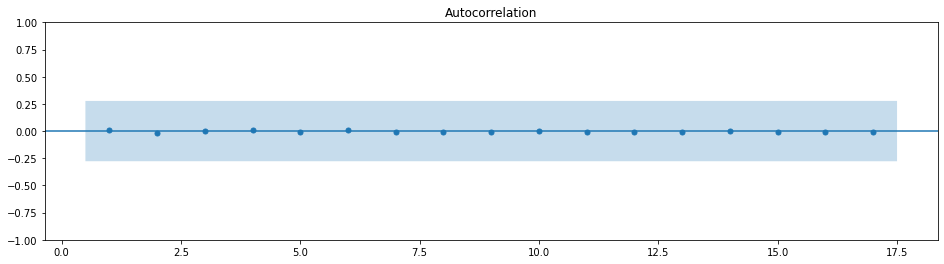

In [148]:
plot_acf(results.resid, zero=False);plt.show()

In [61]:
# from statsmodels.graphics.gofplots import qqplot

# pd.Series(results.resid).plot(kind='kde');plt.show()
# qqplot(results.resid, line='s'); plt.show()

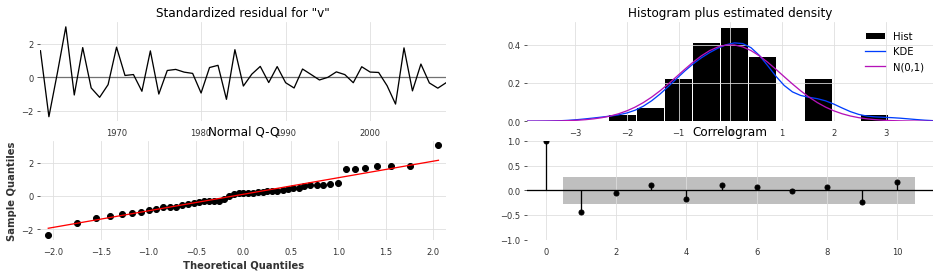

In [62]:
results.plot_diagnostics();plt.show()

In [63]:
(acorr_ljungbox(results.resid, 
                lags=25,
                return_df=True) < 0.05)['lb_pvalue'].sum()

0

In [64]:
from scipy.stats import shapiro
shapiro(results.resid)[1] < 0.05

True

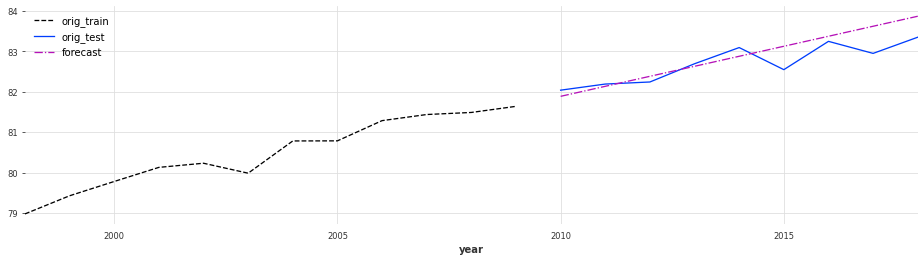

In [65]:
plot_forecast(results, '1998', life_train, life_test)

### There is more

In [150]:
pv, dv, qv = [list(range(3))]*3
vals = combinator([pv, dv, qv])
score = {}
for i, (p, d, q) in enumerate(vals):
    m = ARIMA(life_train, order=(p,d,q))
    res = m.fit()
    y = life_test.values.ravel() 
    y_hat = res.forecast(steps=len(y))
    score[i] = {'order': (p,d,q),
                'AIC':res.aic, 
                'BIC': res.bic,
                'AICc':res.aicc,
                'RMSPE': rmspe(y, y_hat),
                'RMSE' : rmse(y, y_hat),
                'MAPE' : mape(y, y_hat),
                'model': res}

In [152]:
get_best_model(score, 'AIC')

Best model: 8 with lowest AIC score: 7.69747092367904


In [156]:
best_m = get_best_model(score, 'AIC')

Best model: 8 with lowest AIC score: 7.69747092367904


In [157]:
score[8]

{'order': (0, 2, 2),
 'AIC': 7.69747092367904,
 'BIC': 13.311073956402714,
 'AICc': 8.242925469133587,
 'RMSPE': 0.05595582928461146,
 'RMSE': 0.4635773476233591,
 'MAPE': 0.004494177136593728,
 'model': <statsmodels.tsa.arima.model.ARIMAResultsWrapper at 0x7fa7fa49f7f0>}

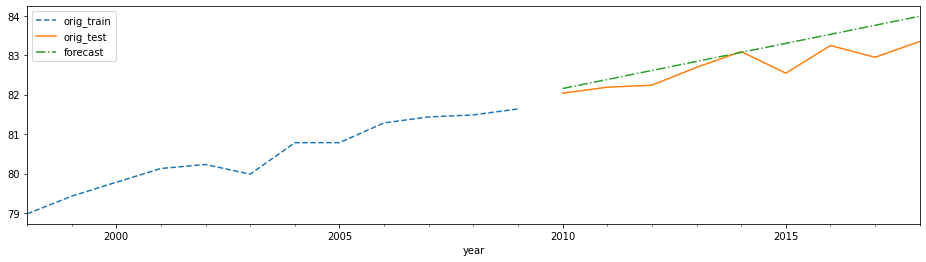

In [158]:
plot_forecast(best_m, '1998', life_train, life_test)

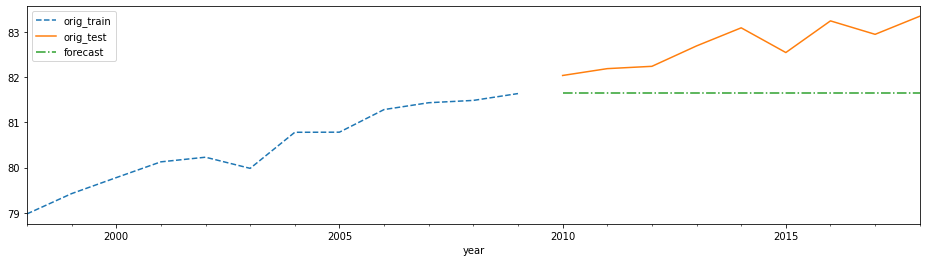

In [159]:
plot_forecast(score[4]['model'], '1998', life_train, life_test)

# Forecasting Univariate Time Series Data with Seasonal ARIMA

In [17]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

<AxesSubplot:xlabel='month'>

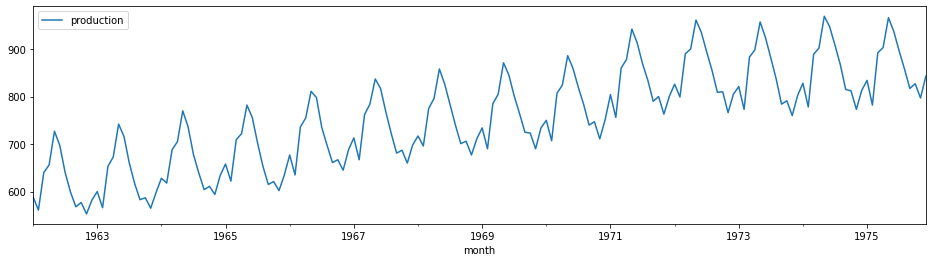

In [18]:
milk.plot()

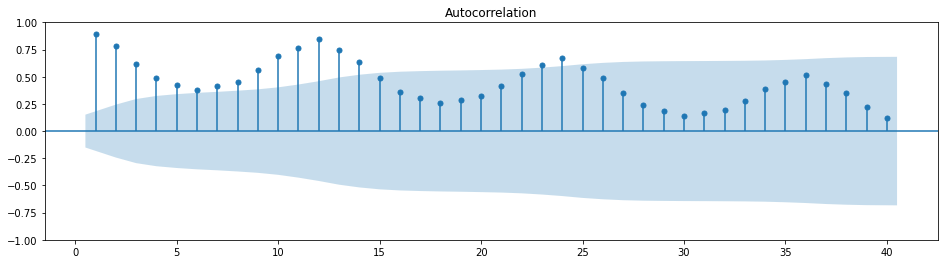

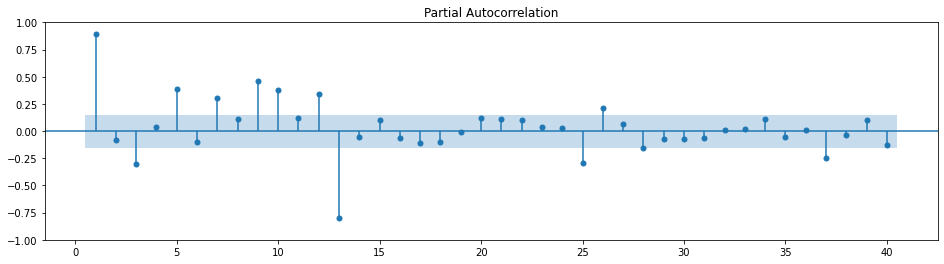

In [19]:
plot_acf(milk, lags=40, zero=False)
plot_pacf(milk, lags=40, zero=False);plt.show()

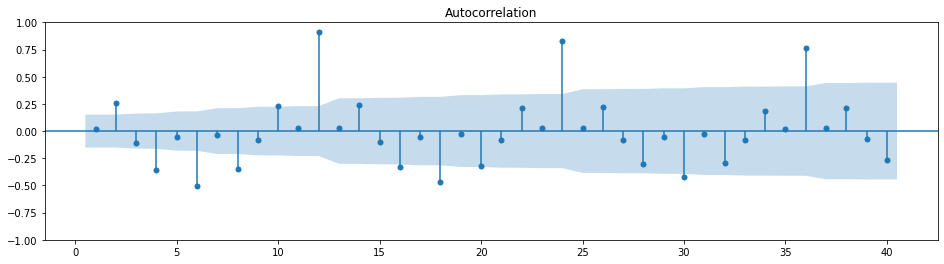

In [20]:
plot_acf(milk.diff(1).dropna(), lags=40, zero=False); plt.show()

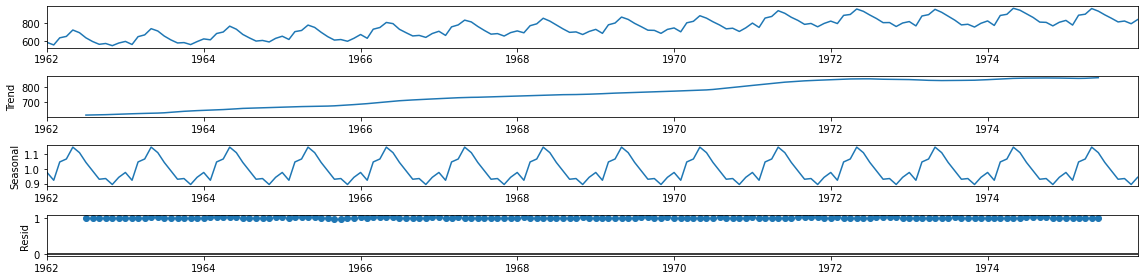

In [21]:
decomposed = seasonal_decompose(milk, period=12, model='multiplicative')
decomposed.plot(); plt.show()

In [22]:
milk_s = decomposed.seasonal

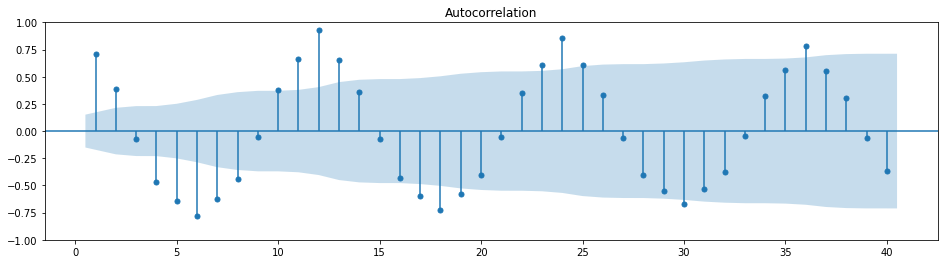

In [23]:
plot_acf(milk_s, zero=False, lags=40);plt.show()

In [24]:
milk_dif_12 = milk.diff(12).dropna()
milk_dif_12_1 = milk.diff(12).diff(1).dropna()

'Non-Stationary	 p-value:0.627426708603034 	 lags:13
'Non-Stationary	 p-value:0.16079880527711382 	 lags:12
'Stationary	 p-value:1.865423431878876e-05 	 lags:11


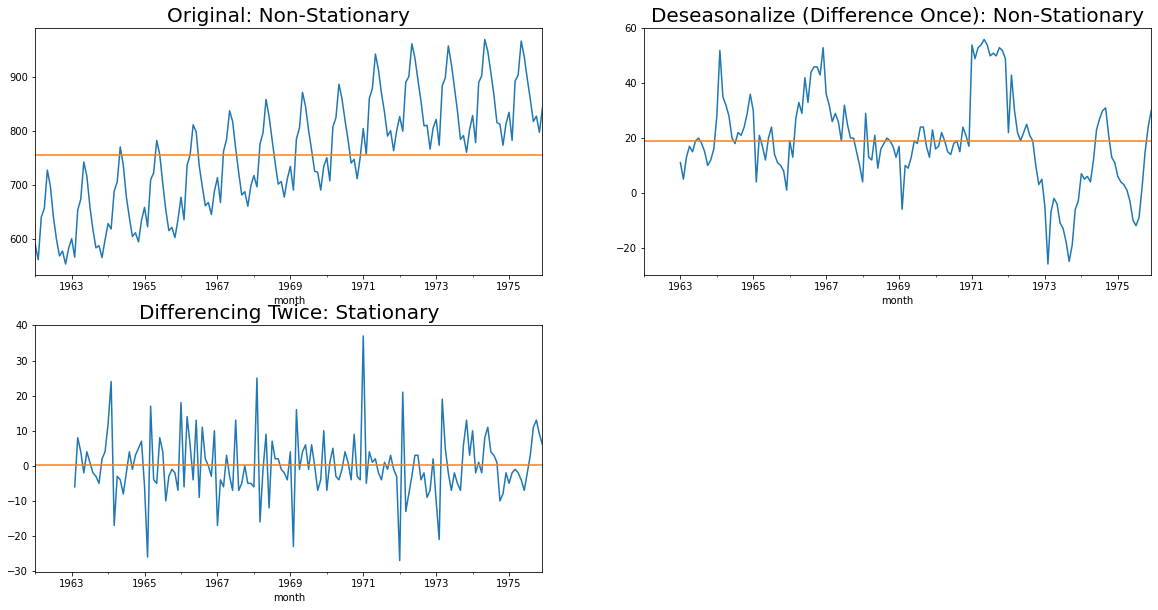

In [51]:
sets = [milk, milk_dif_12, milk_dif_12_1]
desc = ['Original', 'Deseasonalize (Difference Once)', 'Differencing Twice']

fig, ax = plt.subplots(2,2, figsize=(20,10))
index, l = milk.index, milk.shape[0]
for i, (d_set, d_desc) in enumerate(zip(sets, desc)):
    v, r = i // 2, i % 2
    outcome, pval = check_stationarity(d_set)
    d_set.plot(ax= ax[v,r], title=f'{d_desc}: {outcome}', legend=False)
    pd.Series(d_set.mean().values.tolist()*l, index=index).plot(ax=ax[v,r])
    ax[v,r].title.set_size(20)
ax[1,1].set_visible(False)
plt.show()

## Determine AR and MA terms

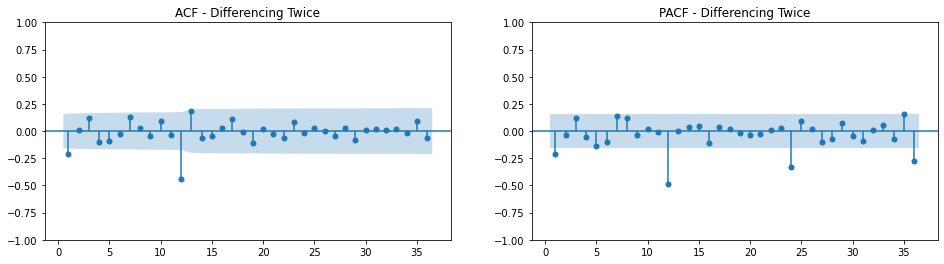

In [52]:
fig, ax = plt.subplots(1,2)
plot_acf(milk_dif_12_1, zero=False, lags=36, ax=ax[0], title=f'ACF - {d_desc}')
plot_pacf(milk_dif_12_1, zero=False, lags=36, ax=ax[1], title=f'PACF - {d_desc}')
plt.show()C

[1, 12, 24, 36, 48]


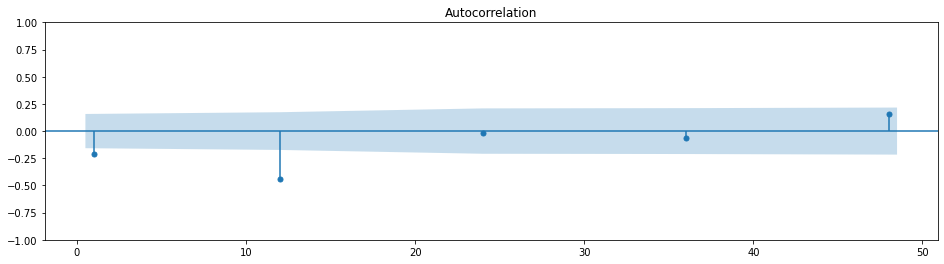

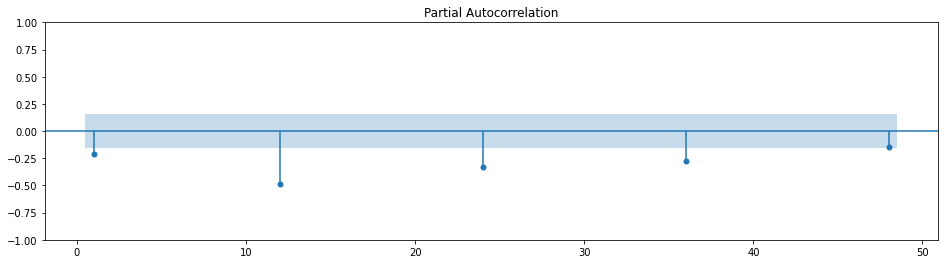

In [55]:
#lags = [1, 12, 24, 36, 48]
lags = [i for i in range(12, 60, 12)]
lags.insert(0, 1)
print(lags)
plot_acf(milk.diff(12).diff(1).dropna(),zero=False, lags=lags)
plot_pacf(milk.diff(12).diff(1).dropna(),zero=False, lags=lags);

## Fitting a SARIMA Model

In [56]:
sarima_model = SARIMAX(milk_train, 
                       order=(0,1,1),
                       seasonal_order=(0,1,1,12))
model = sarima_model.fit(disp=0)

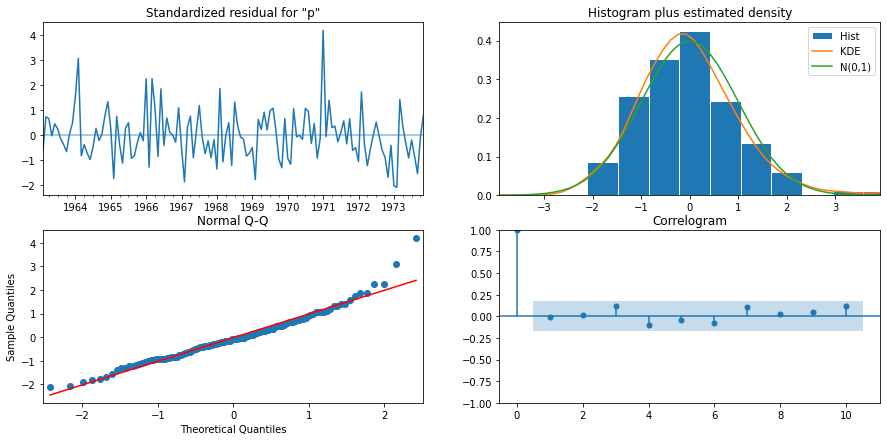

In [57]:
model.plot_diagnostics(figsize=(15,7)); plt.show()

In [58]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                         production   No. Observations:                  143
Model:             SARIMAX(0, 1, 1)x(0, 1, 1, 12)   Log Likelihood                -448.668
Date:                            Thu, 03 Feb 2022   AIC                            903.335
Time:                                    08:49:50   BIC                            911.938
Sample:                                01-01-1962   HQIC                           906.831
                                     - 11-01-1973                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.2811      0.084     -3.331      0.001      -0.446      -0.116
ma.S.L12      -0.6334      0.083     -7.653      0.000      -0.796      -0.471
sigma2        55.5239      5.753      9.650      0.000      44.247      66.800
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):                35.77
Prob(Q):                              0.92   Prob(JB):                         0.00
Heteroskedasticity (H):               1.15   Skew:                             0.82
Prob(H) (two-sided):                  0.65   Kurtosis:                         4.98
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

<AxesSubplot:xlabel='month'>

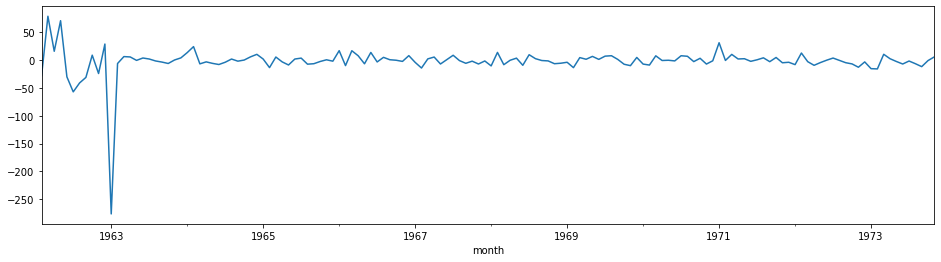

In [59]:
model.resid[1:].plot()

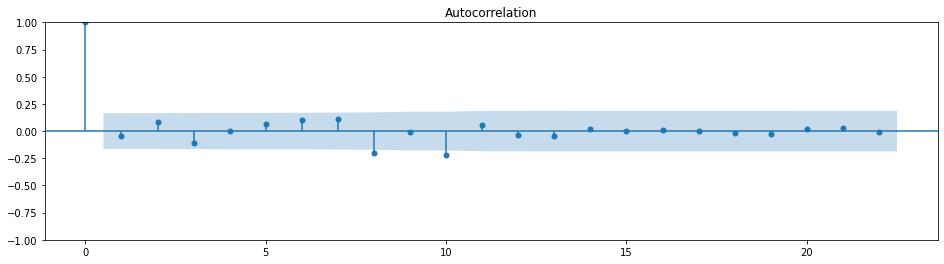

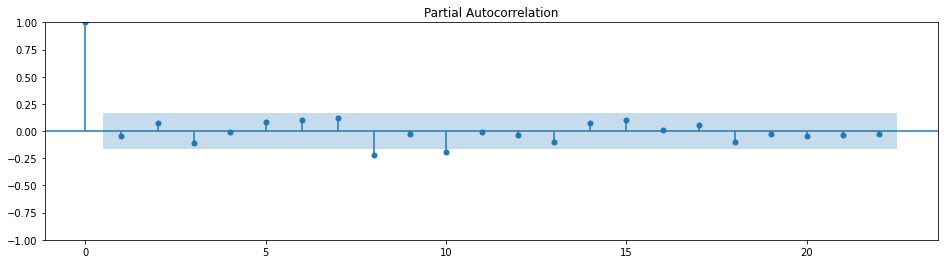

In [60]:
plot_acf(model.resid[1:])
plot_pacf(model.resid[1:]); plt.show()

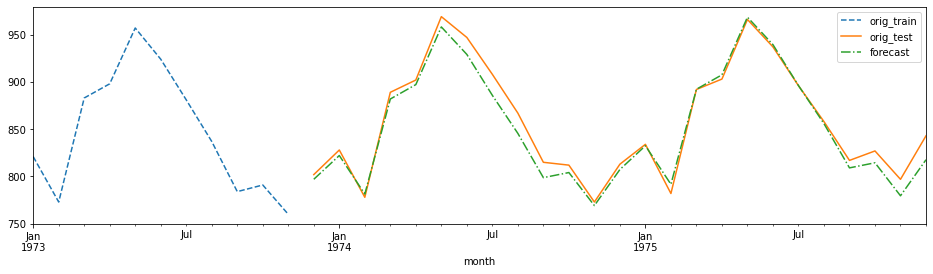

In [72]:
plot_forecast(model, '1973', milk_train, milk_test)

<AxesSubplot:xlabel='month'>

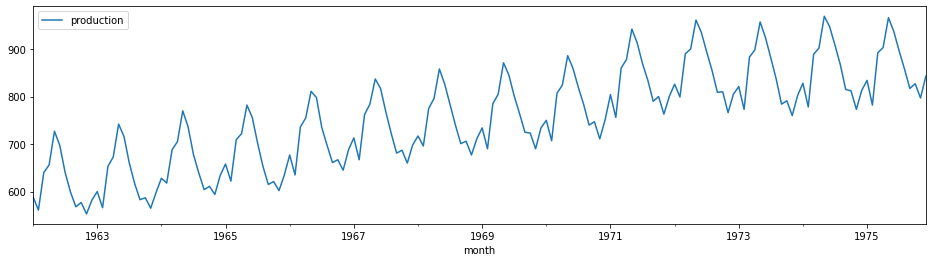

In [62]:
milk.plot()
model.forecast(steps=n).plot(style='-')

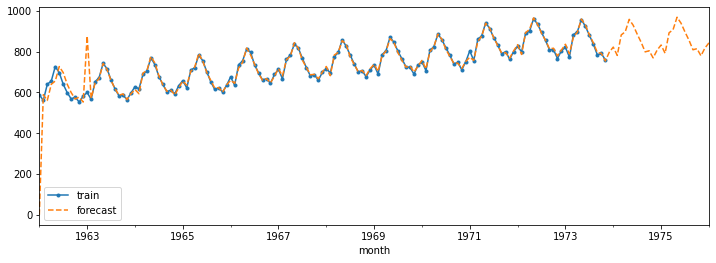

In [63]:
n = milk.shape[0]
milk_train.plot(style='.-', figsize=(12,4))
model.predict(end=n).plot(style='--')
plt.legend(['train', 'forecast'])

### There is more

In [78]:
%%time
P_ns, D_ns, Q_ns = [list(range(3))]*3
P_s, D_s, Q_s = [list(range(2))]*3

vals = combinator([P_ns, D_ns, Q_ns, P_s, D_s, Q_s])
score = {}
for i, (p, d, q, P, D, Q) in enumerate(vals):
    if i%15 == 0:
        print(f'Running model #{i} using SARIMA({p},{d},{q})({P},{D},{Q},12)')
    m = SARIMAX(milk_train, 
                order=(p,d,q),
                seasonal_order=(P, D, Q, 12),
                enforce_stationarity=False)
    res = m.fit(disp=0)
    y = milk_test.values.ravel() 
    y_hat = res.forecast(steps=len(y))
    score[i] = {'non-seasonal order': (p,d,q),
                'seasonal order': (P, D, Q),
                'AIC':res.aic, 
                'AICc': res.aicc,
                'BIC': res.bic,
                'RMSPE': rmspe(y, y_hat),
                'RMSE' : rmse(y, y_hat),
                'MAPE' : mape(y, y_hat),
                'model': res}

Running model #0 using SARIMA(0,0,0)(0,0,0,12)
Running model #15 using SARIMA(0,0,1)(1,1,1,12)
Running model #30 using SARIMA(0,1,0)(1,1,0,12)
Running model #45 using SARIMA(0,1,2)(1,0,1,12)
Running model #60 using SARIMA(0,2,1)(1,0,0,12)
Running model #75 using SARIMA(1,0,0)(0,1,1,12)
Running model #90 using SARIMA(1,0,2)(0,1,0,12)
Running model #105 using SARIMA(1,1,1)(0,0,1,12)
Running model #120 using SARIMA(1,2,0)(0,0,0,12)
Running model #135 using SARIMA(1,2,1)(1,1,1,12)
Running model #150 using SARIMA(2,0,0)(1,1,0,12)
Running model #165 using SARIMA(2,0,2)(1,0,1,12)
Running model #180 using SARIMA(2,1,1)(1,0,0,12)
Running model #195 using SARIMA(2,2,0)(0,1,1,12)
Running model #210 using SARIMA(2,2,2)(0,1,0,12)
CPU times: user 52.4 s, sys: 1.12 s, total: 53.5 s
Wall time: 54 s


In [89]:
best_model = get_best_model(score, 'AIC')

Best model: 211 with lowest AIC score: 795.421765316976


In [85]:
score[211]

{'non-seasonal order': (2, 2, 2),
 'seasonal order': (0, 1, 1),
 'AIC': 795.421765316976,
 'AICc': 796.206812045948,
 'BIC': 811.838956007343,
 'RMSPE': 0.17818985654535582,
 'RMSE': 15.135857809208446,
 'MAPE': 0.014454257995644617,
 'model': <statsmodels.tsa.statespace.sarimax.SARIMAXResultsWrapper at 0x7f775d6e0ee0>}

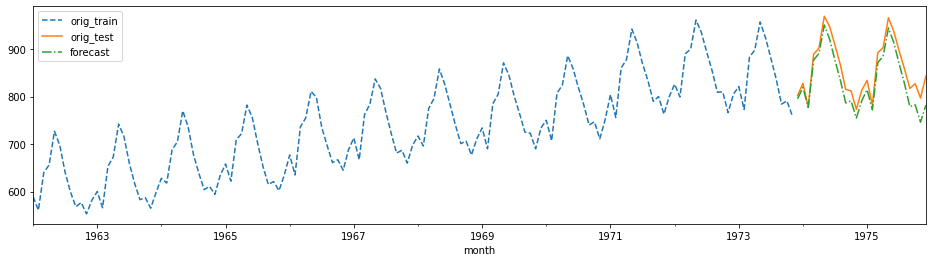

In [86]:
plot_forecast(best_model, '1962', milk_train, milk_test)